In [ ]:
#external libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime

import matplotlib as mpl
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload

In [2]:
#local imports
from func.DataLoader import gdfLoader,ReadMarkerMap,RSSIDataLoader
from func.utils.getMarkerDictList import getMarkerDictList
from func.FoliumFeatureCreation.RawDataFeatures import RawDataFeatures

In [3]:
MapDataPath="data/cartePalaiseau.csv"
ModuleMapPath="data/carteModulePalaiseau.csv"
Data_Path="data/manipstatic.csv"

saving_output=False

sampling_time=2000#ms #si supérieur à 2000ms il faut implémenter la moyenne dans la liste des rssi dans marker dict list

### Data loading


In [4]:
#Map Data
map_gdf=gdfLoader(MapDataPath)
map_gdf.to_crs(epsg=4326, inplace=True)
#marker data
marker_gdf=ReadMarkerMap(ModuleMapPath)
#rssi data
rssi_df=RSSIDataLoader(Data_Path)

In [11]:
#to optimize the getting of location of macModule, we create a dictionnary
MacModuleLocation = marker_gdf.set_index("macModule").to_dict()["geometry"]
#it display the approximation of point location in print but it is not the case in the dataframe
MacModuleLocation

{'A8032A31204E': <POINT (2.201 48.713)>,
 'C45BBE39F42A': <POINT (2.201 48.713)>,
 'C45BBE39F9AE': <POINT (2.201 48.713)>,
 'A8032A311FAA': <POINT (2.201 48.713)>,
 'C45BBE39F56A': <POINT (2.201 48.713)>,
 'C45BBE37B346': <POINT (2.201 48.713)>,
 'C45BBE386952': <POINT (2.201 48.713)>,
 'C45BBE386362': <POINT (2.201 48.713)>,
 'C45BBE384CD2': <POINT (2.201 48.713)>,
 'C45BBE39870E': <POINT (2.201 48.713)>,
 'A8032A312052': <POINT (2.201 48.713)>,
 'A8032A31204A': <POINT (2.201 48.713)>,
 'A8032A311F6A': <POINT (2.201 48.713)>,
 'A8032A311F56': <POINT (2.201 48.713)>,
 'C45BBE38FEAA': <POINT (2.201 48.713)>,
 'A8032A30FBFE': <POINT (2.2 48.713)>,
 'A8032A311DAA': <POINT (2.201 48.713)>,
 'A8032A30FB9E': <POINT (2.2 48.713)>,
 'C45BBE39F4D6': <POINT (2.201 48.713)>,
 'A8032A311F96': <POINT (2.201 48.713)>,
 'A8032A311F66': <POINT (2.202 48.713)>,
 'A8032A311FBA': <POINT (2.202 48.713)>,
 'A8032A311F52': <POINT (2.201 48.713)>,
 'A8032A311DBA': <POINT (2.201 48.713)>,
 'A8032A30FBEE': <PO

### Bind the received RSSI Data to the CartoModule Marker on Map

In [6]:
#create a list of timestamps between min_timestamp and max_timestamp with a step of sampling_time
min_timestamp=rssi_df.iloc[0]['timestamp']+pd.Timedelta(sampling_time, unit="ms")
max_timestamp=rssi_df.iloc[-1]['timestamp']
timestamp_list= pd.date_range(start=min_timestamp, end=max_timestamp, freq=str(sampling_time)+"ms").tolist()


In [7]:
MarkerDictList=getMarkerDictList(rssi_df, timestamp_list)

colormap creation

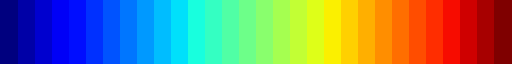

In [8]:
cmap = mpl.colormaps['jet'].resampled(30)
cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, 30)))
cmap

In [9]:
raw_data_features=RawDataFeatures(MarkerDictList,timestamp_list,MacModuleLocation,cmap)
MarkerLayer=TimestampedGeoJson(
                    {"type": "FeatureCollection","features": raw_data_features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,
                    auto_play=True)

In [10]:
m = folium.Map(location = [48.713166904690254, 2.2007200581389768],max_zoom=30, zoom_start=20,crs="EPSG3857")
folium.TileLayer('stamenterrain').add_to(m)
tooltip = folium.features.GeoJsonTooltip(fields=['ID_element', 'nom'], 
                                        labels=True,
                                        stick=False)
folium.GeoJson(map_gdf, tooltip=tooltip).add_to(m)
MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/marker_map.html')
m